In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import imageio
import sys

In [2]:
class EM():
    
    def __init__(self, K):
        self.K = K
        
    def fit(self, X):
        K = self.K
        M, S, P, mixtureMatrix = self.initializeMatrices(K)
        tol = 0.0001
        iters = 300
        self.logLikelihoods = []
        oldL = self.logLikelihood(mixtureMatrix )

        for i in range(iters):
            sys.stdout.write('\r'+ "K=" + str(K) +", iterations: " + str(i))
            Gamma = self.calc_Gamma(mixtureMatrix)
            Nk = self.calc_Nk(Gamma)
            M = self.calc_M(X, Gamma, Nk)
            S = self.calc_S(X, Gamma, Nk , M)
            P = self.calc_P(Nk,X.shape[0])
            
            mixtureMatrix = self.GaussianMixture(X, M, S, P)
            L = self.logLikelihood(mixtureMatrix )
            self.logLikelihoods.append(L)

            if (L - oldL < 0):
                print("\nThere is a problem!")
                return
            elif (L - oldL < tol ):
                break
                
            oldL = L
        
        print("\nSuccessful")
        self.Xpred = M[ Gamma.argmax(axis=1) ]
        

    def GaussianMixture(self, X, M, S, P ):
        S = np.array([ np.eye(X.shape[1])*Sk for Sk in S])
        mixture = np.zeros((X.shape[0], M.shape[0]))
        for k in range(M.shape[0]):
            mixture[:, k] = stats.multivariate_normal(M[k], S[k]).pdf(X)
        return P.T * mixture        

    def calc_Gamma(self, mixtureMatrix):  # returns an (N x K) array
        Gamma = mixtureMatrix
        Gamma = Gamma / np.sum(Gamma , axis=1).reshape(-1,1)
        return Gamma

    def calc_Nk(self, Gamma):            # returns an (1 x K) array
        return np.sum(Gamma , axis=0).reshape(-1,1)

    def calc_M(self, X, Gamma, Nk):       # returns an (K x D) array
        return Gamma.T.dot(X) / Nk

    def calc_S(self, X, Gamma, Nk, M):    # returns an (K x 1) array
        S = np.ones((M.shape[0],1))
        for k in range(M.shape[0]):
            S[k] = np.sum(np.sum(Gamma[:, k].reshape((-1, 1))*np.square(X- M[k]), axis=1))

        return np.array(S) /(X.shape[1] * Nk )

    def calc_P(self, Nk, N):        # returns an (K x 1) array
        return Nk/N

    def initializeMatrices(self, K):
        M = np.random.uniform(0,1,(K,X.shape[1]))
        S = np.random.uniform(0, 1, (K,1))
        P = np.ones((K,1)) * 1/K
        mixtureMatrix = self.GaussianMixture(X, M, S, P)
        return M, S, P, mixtureMatrix

    def logLikelihood(self,  mixtureMatrix ):
        return np.sum(np.log(np.sum(mixtureMatrix, axis=1)))

    def reconstError(self, X ):
        return np.linalg.norm( (X-self.Xpred)*255 ) / X.shape[0]

    def savePredictedImage(self, shape):
        Xpred = (self.Xpred*255).astype(np.uint8)
        Xpred = Xpred.reshape(shape)
        imageio.imwrite('images/im_K' + str(self.K) + '.jpg' ,Xpred )



In [3]:
def runForAllK(Xtrue, shape):
    for K in [1, 2, 4, 8, 16, 32, 64]:
        em = EM(K)
        em.fit(Xtrue)
        em.savePredictedImage(shape)
        print("Reconstruction error= ", em.reconstError(Xtrue) , "\n")

In [4]:
im = imageio.imread('images/im.jpg')       #read image
shape = im.shape
im = im.reshape((im.shape[0]*im.shape[1],3))
X = im/255

In [5]:
%%time
em = EM(3)         #test for K=3
em.fit(X)
em.savePredictedImage(shape)

K=3, iterations: 92
Successful
CPU times: user 25.8 s, sys: 1.83 s, total: 27.6 s
Wall time: 12.7 s


Reconstuction error when K=3: 0.06908231052770722


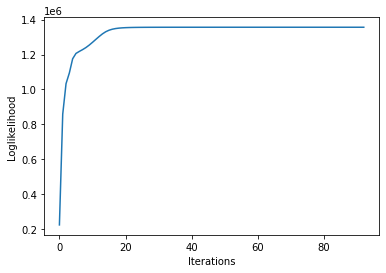

In [6]:
plt.plot( np.arange(len(em.logLikelihoods)),em.logLikelihoods )   #results for K=3
plt.xlabel("Iterations")
plt.ylabel("Loglikelihood")

print("Reconstuction error when K=3:", em.reconstError(X))

In [7]:
%%time
runForAllK(X,shape)   #takes 25 minutes

K=1, iterations: 1
Successful
Reconstruction error=  0.17303304487092772 

K=2, iterations: 23
Successful
Reconstruction error=  0.09147208159975455 

K=4, iterations: 170
Successful
Reconstruction error=  0.05366774386694557 

K=8, iterations: 254
Successful
Reconstruction error=  0.034094456472887794 

K=16, iterations: 299
Successful
Reconstruction error=  0.02532530225338679 

K=32, iterations: 299
Successful
Reconstruction error=  0.01849692361605513 

K=64, iterations: 299
Successful
Reconstruction error=  0.012538111156193042 

CPU times: user 49min 21s, sys: 2min 4s, total: 51min 25s
Wall time: 25min 39s
